### 8.1.1. 统计工具
处理序列数据需要统计工具和新的深度神经网络架构。
为了简单起见，我们以 图所示的股票价格（富时100指数）为例。
![富时100指数](imgs/8_1_1_统计工具1.png)

用$x_t$表示价格，
即在时间步 $t∈Z^+$时，观察到的价格$x_t$。
请注意，$t$对于文本中的序列通常是离散的，并在整数或其子集上变化。
假设一个交易员想在$t$日的股市中交易良好，于是通过以下途径预测$x_t$:
$$x_t ∽ P\{x_t | x_{t-1},...,x_t\}$$

#### 8.1.1.1. 自回归模型
为了实现这个预测，交易员可以使用回归模型， 例如在 3.3节中训练的模型。 仅有一个主要问题：输入数据的数量， 输入 xt−1,…,x1 本身因 t 而异。 也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加， 因此需要一个近似方法来使这个计算变得容易处理。 本章后面的大部分内容将围绕着如何有效估计  $P(x_t∣x_{t−1},…,x_1)$ 展开。 简单地说，它归结为以下两种策略。

+ 第一种策略
就假设在现实情况下相当长的序列$x_{t-1},...,x_1$可能是不必要的，
因此我们只需要满足某个时间长度为τ的时间跨度，即使用观测序列$x_{t-1},...,x_{t-τ}$。
当下获得的最直接的好处是参数的数量总是保持不变的，至少在t > τ是如此。
##### 这种模型被称为自回归模型Autoregressive models，因为它们是对自己执行回归
+ 第二种策略
如图所示，是保留一些**对过去观测的总结$h_t$**，并且同时更新**预测$\^x_t$**和总结$h_t$。
这就产生了基于$\^x_t = P(x_t | h_t)$估计$x_t$，以及公式$h_t = g(h_{t-1},x_{t-1}$更新的模型
##### 由于$h_t$从未被观测到，这类模型也被称为隐变量自回归模型Latent autoregressive models。
![隐变量自回归模型](imgs/8_1_1_1_自回归模型1.png)

#### 8.1.1.2. 马尔可夫模型
![马尔可夫模型](imgs/8_1_1_2马尔可夫模型1.png)

### 8.1.2. 训练
先，我们生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据， 时间步为 1,2,…,1000 。

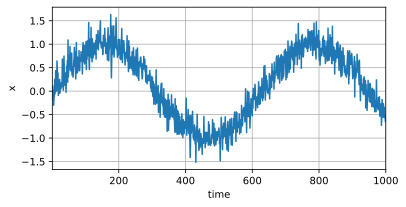

In [11]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))
# time是横轴，x是产生的与横轴相关的sin数据

接下来，我们把这个序列模型转化为模型的“特征-标签”对。
基于嵌入维度τ ，我们将数据映射为数据对$y_t=x_t$ 和$x_t=[x_{t−τ},…,x_{t−1}]$。 你可能已经注意到，这比我们提供的数据样本少了τ个，  因为我们没有足够的历史记录来描述前 τ 个数据样本。 一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项； 另一个方法是用零填充序列。 在这里，我们仅使用前600个“特征－标签”对进行训练。

> 这句话是说，最末端的序列没有足够的观测长度，1，2，3，4，5，6。 6可以观测5432，1却缺少观测

In [12]:
# 没有足够的数据去描述前tau个样本
tau = 4
# T = 1000个时间步，features共996行，4列
features = torch.zeros((T - tau, tau))
for i in range(tau):
    # 对feature的每一列996个数据做处理，
    # 赋值为x的长度为T-tau=996的数据，窗口朝着x的尾部移动
    features[:, i] = x[i: T - tau + i]
# label是x的从弟tau之后的真实值，（加了噪声的）
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)
x.shape, features.shape, labels.shape

(torch.Size([1000]), torch.Size([996, 4]), torch.Size([996, 1]))

In [13]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [14]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.059122
epoch 2, loss: 0.057094
epoch 3, loss: 0.055883
epoch 4, loss: 0.053993
epoch 5, loss: 0.052927


由于训练损失很小，因此我们期望模型能有很好的工作效果。 让我们看看这在实践中意味着什么。 首先是检查[模型预测下一个时间步]的能力， 也就是单步预测（one-step-ahead prediction）。
### 8.1.3 预测

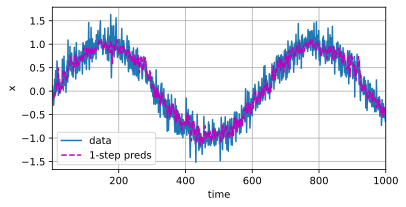

In [15]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

正如我们所料，单步预测效果不错。
即使这些预测的时间步超过了$600+4$（`n_train + tau`），
其结果看起来仍然是可信的。
然而有一个小问题：如果数据观察序列的时间步只到$604$，
我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$
称为$k$*步预测*（$k$-step-ahead-prediction）。
由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。
换句话说，
##### 我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。
指的是0~K这些时间步
让我们看看效果如何。

##### 根据已有信息，预测后面第K个时间步的信息

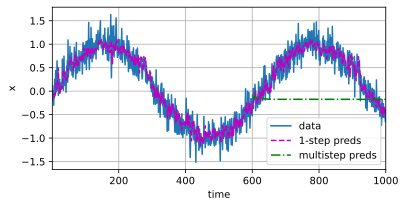

In [16]:
# 初始预测为长度为1000个0向量
multistep_preds = torch.zeros(T)
# 从初始预测到第 600 + 4的预测，赋值为对应的x真实值
multistep_preds[: n_train + tau] = x[: n_train + tau]
# 从600 + 4开始，到1000
for i in range(n_train + tau, T):
    # 逐个获得时间步604之后的值（没有训练数据）
    multistep_preds[i] = net(
        # 从u前tau个到i，逐个华为行向量
        multistep_preds[i - tau:i].reshape((1, -1)))
# 这张图应该关注时间步604之后的值，因为不是由真实数据训练的
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。
经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。
为什么这个算法效果这么差呢？事实是由于错误的累积：
假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。
于是，步骤$2$的输入被扰动了$\epsilon_1$，
结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，
其中$c$为某个常数，后面的预测误差依此类推。
因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，
但超过这一点，精度就会迅速下降。
我们将在本章及后续章节中讨论如何改进这一点。

基于$k = 1, 4, 16, 64$，通过对整个序列预测的计算，
让我们[**更仔细地看一下$k$步预测**]的困难。


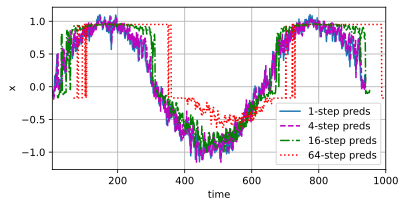

In [17]:
# 最大时间步64
max_steps = 64
# 不同的时间步，意味着数据尽头的不同
# 如果时间步是64， 前64 + tau个数据都无法预测
# feature的形状也不同
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。 虽然“ 步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。
虽然“$4$步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。

## 小结

* 内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于你所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。
* 序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。
* 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。
* 对于直到时间步$t$的观测序列，其在时间步$t+k$的预测输出是“$k$步预测”。随着我们对预测时间$k$值的增加，会造成误差的快速累积和预测质量的极速下降。